In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def parse_fio_file(filepath):
    with open(filepath, 'r') as f:
        content = f.read()
    
    filename = Path(filepath).stem
    
    if 'bs1m' in filename:
        block_size = 1024
    else:
        bs_match = re.search(r'bs(\d+)k', filename)
        block_size = int(bs_match.group(1)) if bs_match else None
    
    if 'read100' in filename:
        read_pct, write_pct = 100, 0
    elif 'write100' in filename:
        read_pct, write_pct = 0, 100
    else:
        read_match = re.search(r'read(\d+)write(\d+)', filename)
        if read_match:
            read_pct = int(read_match.group(1))
            write_pct = int(read_match.group(2))
        else:
            read_pct, write_pct = None, None
    
    read_bw = None
    read_iops = None
    write_bw = None
    write_iops = None
    read_lat = None
    write_lat = None
    
    read_match = re.search(r'read: IOPS=(\d+(?:\.\d+)?), BW=(\d+(?:\.\d+)?)(\w+)/s', content)
    if read_match:
        read_iops = float(read_match.group(1))
        read_bw = float(read_match.group(2))
        unit = read_match.group(3)
        if unit == 'MiB':
            read_bw = read_bw * 1024
    
    write_match = re.search(r'write: IOPS=(\d+(?:\.\d+)?), BW=(\d+(?:\.\d+)?)(\w+)/s', content)
    if write_match:
        write_iops = float(write_match.group(1))
        write_bw = float(write_match.group(2))
        unit = write_match.group(3)
        if unit == 'MiB':
            write_bw = write_bw * 1024
    
    read_section = re.search(r'read: IOPS.*?(?=write:|Run status|$)', content, re.DOTALL)
    if read_section:
        read_lat_match = re.search(r'clat \((\w+)\): min=\d+, max=[\d.k]+, avg=(\d+(?:\.\d+)?)', read_section.group(0))
        if read_lat_match:
            unit = read_lat_match.group(1)
            read_lat = float(read_lat_match.group(2))
            if unit == 'usec':
                read_lat = read_lat / 1000
    
    write_section = re.search(r'write: IOPS.*?(?=\s+lat \(|Run status|$)', content, re.DOTALL)
    if write_section:
        write_lat_match = re.search(r'clat \((\w+)\): min=\d+, max=[\d.k]+, avg=(\d+(?:\.\d+)?)', write_section.group(0))
        if write_lat_match:
            unit = write_lat_match.group(1)
            write_lat = float(write_lat_match.group(2))
            if unit == 'usec':
                write_lat = write_lat / 1000
    
    return {
        'filename': filename,
        'block_size_kb': block_size,
        'read_percent': read_pct,
        'write_percent': write_pct,
        'read_bw_kib': read_bw,
        'read_iops': read_iops,
        'write_bw_kib': write_bw,
        'write_iops': write_iops,
        'read_lat_avg': read_lat,
        'write_lat_avg': write_lat
    }

def load_fio_results(directory):
    results = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            result = parse_fio_file(filepath)
            results.append(result)
    return pd.DataFrame(results)

In [2]:
df = load_fio_results('fio/test_suite_sd_results')
df = df.sort_values(['block_size_kb', 'read_percent'])
print(f"Loaded {len(df)} test results")
print("\nData preview:")
df

Loaded 54 test results

Data preview:


,filename,block_size_kb,read_percent,write_percent,read_bw_kib,read_iops,write_bw_kib,write_iops,read_lat_avg,write_lat_avg
35,bs4k_write100,4,0,100,NaN,NaN,5751.0,1437.0,NaN,2.77743
31,bs4k_read20write80,4,20,80,593.0,148.0,2418.0,604.0,13.96943,3.18262
32,bs4k_read40write60,4,40,60,1727.0,431.0,2622.0,655.0,5.91093,2.19364
33,bs4k_read60write40,4,60,40,3568.0,892.0,2427.0,606.0,3.58240,1.28567
34,bs4k_read80write20,4,80,20,5402.0,1350.0,1386.0,346.0,2.93470,0.05549
30,bs4k_read100,4,100,0,22118.4,5537.0,NaN,NaN,0.71623,NaN
53,bs8k_write100,8,0,100,NaN,NaN,7733.0,966.0,NaN,4.12910
49,bs8k_read20write80,8,20,80,626.0,78.0,2603.0,325.0,32.73026,4.40809
50,bs8k_read40write60,8,40,60,1782.0,222.0,2741.0,342.0,12.37000,3.61781
51,bs8k_read60write40,8,60,40,3423.0,427.0,2363.0,295.0,6.37748,4.27836


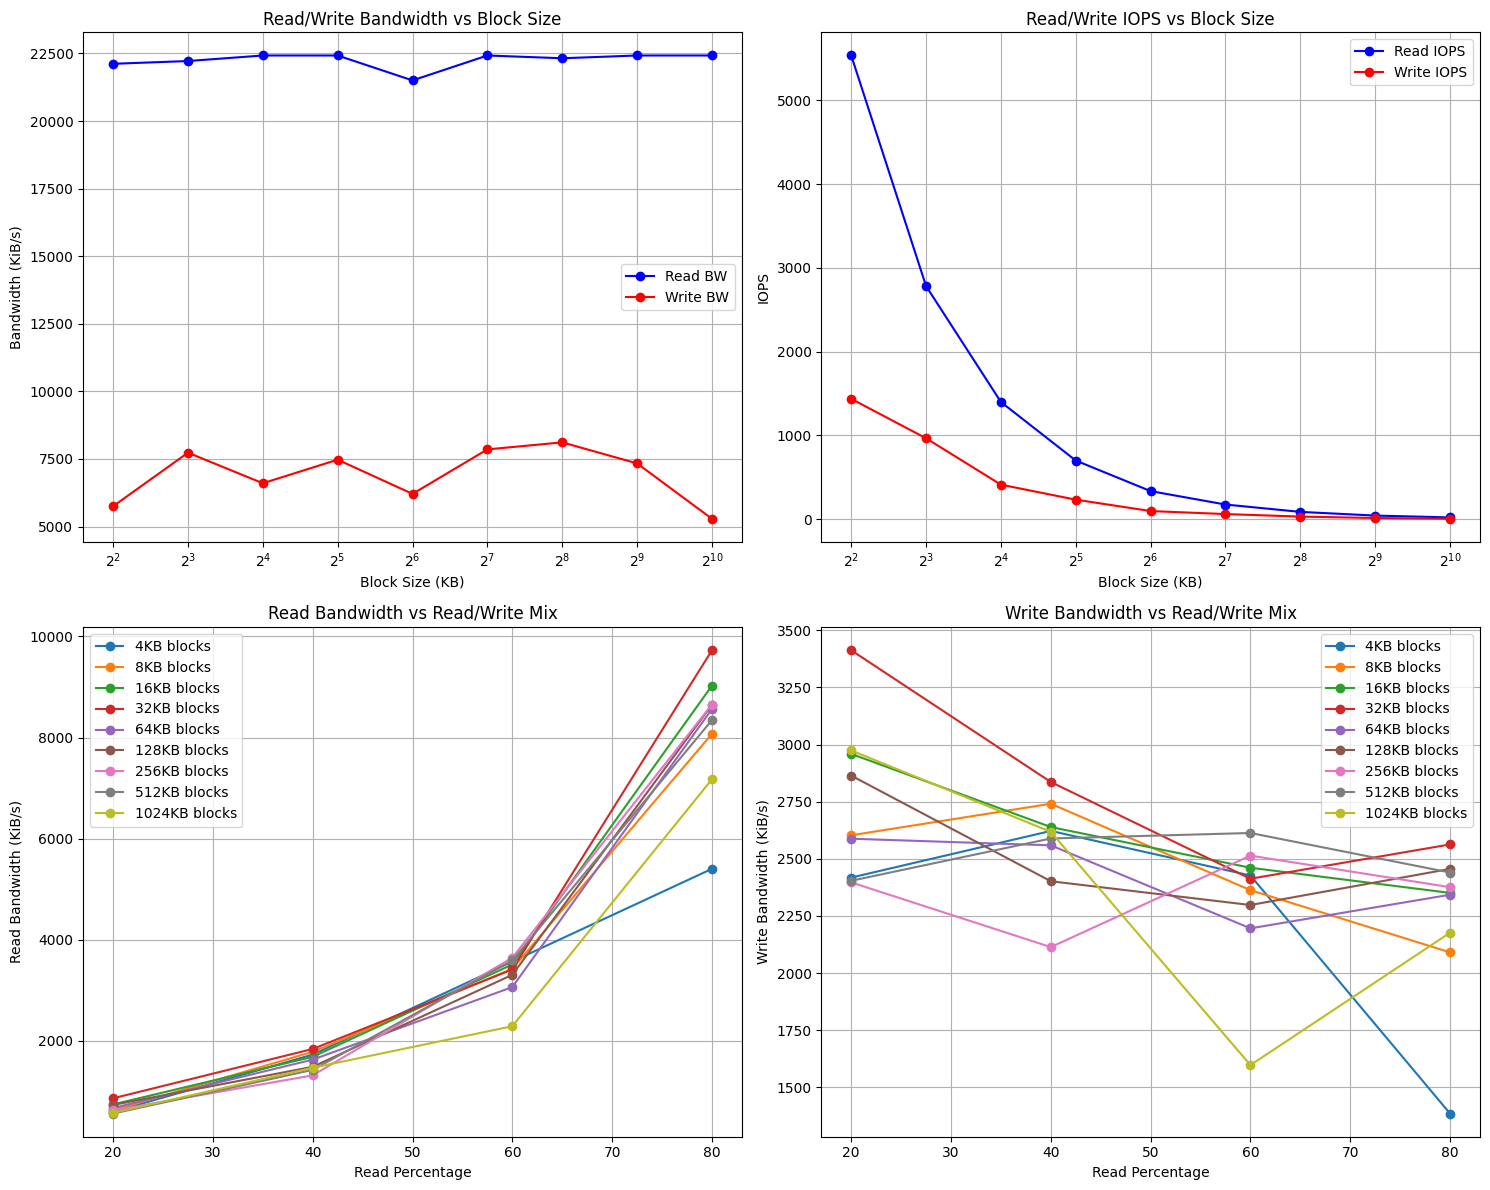

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

read_only = df[df['read_percent'] == 100]
write_only = df[df['write_percent'] == 100]

axes[0,0].plot(read_only['block_size_kb'], read_only['read_bw_kib'], 'b-o', label='Read BW')
axes[0,0].plot(write_only['block_size_kb'], write_only['write_bw_kib'], 'r-o', label='Write BW')
axes[0,0].set_xlabel('Block Size (KB)')
axes[0,0].set_ylabel('Bandwidth (KiB/s)')
axes[0,0].set_title('Read/Write Bandwidth vs Block Size')
axes[0,0].set_xscale('log', base=2)
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(read_only['block_size_kb'], read_only['read_iops'], 'b-o', label='Read IOPS')
axes[0,1].plot(write_only['block_size_kb'], write_only['write_iops'], 'r-o', label='Write IOPS')
axes[0,1].set_xlabel('Block Size (KB)')
axes[0,1].set_ylabel('IOPS')
axes[0,1].set_title('Read/Write IOPS vs Block Size')
axes[0,1].set_xscale('log', base=2)
axes[0,1].legend()
axes[0,1].grid(True)

mixed_df = df[(df['read_percent'] > 0) & (df['read_percent'] < 100)]
if not mixed_df.empty:
    for bs in mixed_df['block_size_kb'].unique():
        bs_data = mixed_df[mixed_df['block_size_kb'] == bs]
        axes[1,0].plot(bs_data['read_percent'], bs_data['read_bw_kib'], 'o-', label=f'{bs}KB blocks')
    axes[1,0].set_xlabel('Read Percentage')
    axes[1,0].set_ylabel('Read Bandwidth (KiB/s)')
    axes[1,0].set_title('Read Bandwidth vs Read/Write Mix')
    axes[1,0].legend()
    axes[1,0].grid(True)

if not mixed_df.empty:
    for bs in mixed_df['block_size_kb'].unique():
        bs_data = mixed_df[mixed_df['block_size_kb'] == bs]
        axes[1,1].plot(bs_data['read_percent'], bs_data['write_bw_kib'], 'o-', label=f'{bs}KB blocks')
    axes[1,1].set_xlabel('Read Percentage')
    axes[1,1].set_ylabel('Write Bandwidth (KiB/s)')
    axes[1,1].set_title('Write Bandwidth vs Read/Write Mix')
    axes[1,1].legend()
    axes[1,1].grid(True)

plt.tight_layout()
plt.show()

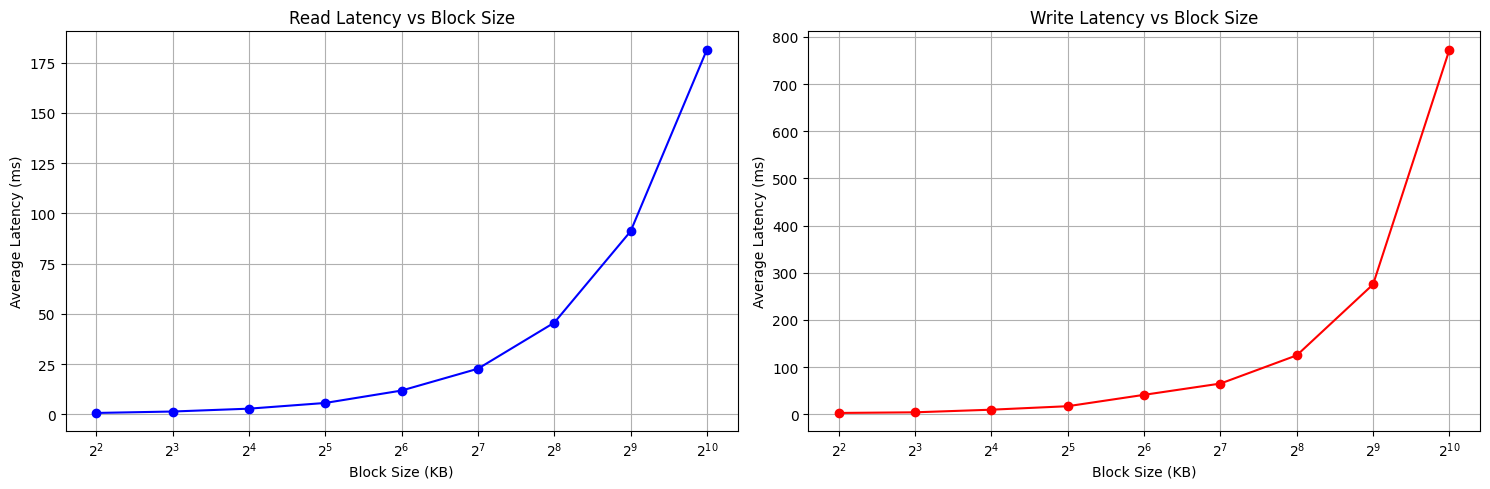

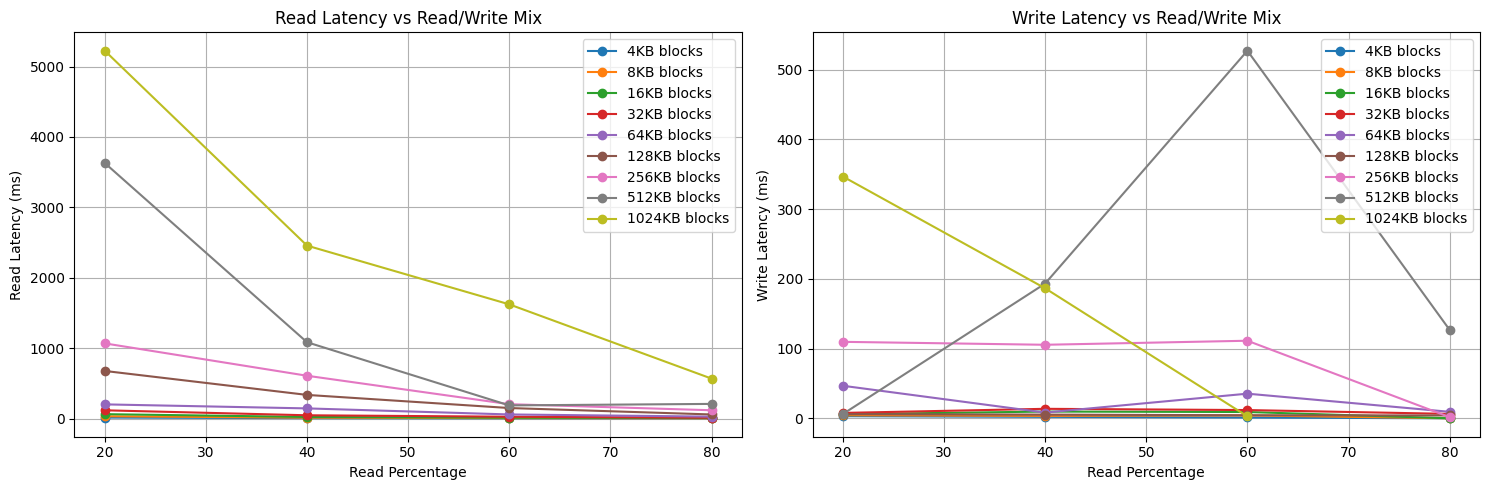

In [7]:
latency_data = df.dropna(subset=['read_lat_avg', 'write_lat_avg'])
if not latency_data.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    read_lat_data = latency_data[latency_data['read_percent'] == 100]
    write_lat_data = latency_data[latency_data['write_percent'] == 100]
    
    if not read_lat_data.empty:
        ax1.plot(read_lat_data['block_size_kb'], read_lat_data['read_lat_avg'], 'b-o')
        ax1.set_xlabel('Block Size (KB)')
        ax1.set_ylabel('Average Latency (ms)')
        ax1.set_title('Read Latency vs Block Size')
        ax1.set_xscale('log', base=2)
        ax1.grid(True)
    
    if not write_lat_data.empty:
        ax2.plot(write_lat_data['block_size_kb'], write_lat_data['write_lat_avg'], 'r-o')
        ax2.set_xlabel('Block Size (KB)')
        ax2.set_ylabel('Average Latency (ms)')
        ax2.set_title('Write Latency vs Block Size')
        ax2.set_xscale('log', base=2)
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    mixed_lat_data = df[(df['read_percent'] > 0) & (df['read_percent'] < 100)]
    if not mixed_lat_data.empty:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        for bs in mixed_lat_data['block_size_kb'].unique():
            bs_data = mixed_lat_data[mixed_lat_data['block_size_kb'] == bs].dropna(subset=['read_lat_avg'])
            if not bs_data.empty:
                ax1.plot(bs_data['read_percent'], bs_data['read_lat_avg'], 'o-', label=f'{bs}KB blocks')
        
        for bs in mixed_lat_data['block_size_kb'].unique():
            bs_data = mixed_lat_data[mixed_lat_data['block_size_kb'] == bs].dropna(subset=['write_lat_avg'])
            if not bs_data.empty:
                ax2.plot(bs_data['read_percent'], bs_data['write_lat_avg'], 'o-', label=f'{bs}KB blocks')
        
        ax1.set_xlabel('Read Percentage')
        ax1.set_ylabel('Read Latency (ms)')
        ax1.set_title('Read Latency vs Read/Write Mix')
        ax1.legend()
        ax1.grid(True)
        
        ax2.set_xlabel('Read Percentage')
        ax2.set_ylabel('Write Latency (ms)')
        ax2.set_title('Write Latency vs Read/Write Mix')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

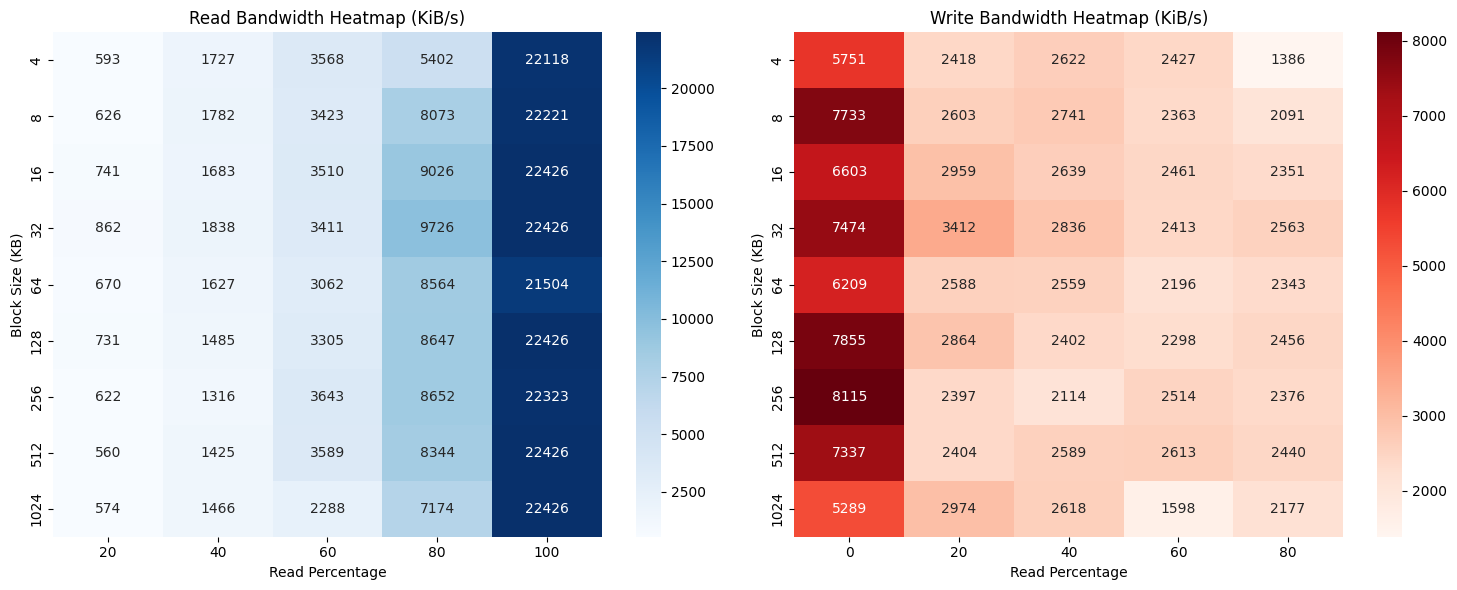

In [5]:
pivot_read_bw = df.pivot_table(values='read_bw_kib', index='block_size_kb', columns='read_percent', fill_value=0)
pivot_write_bw = df.pivot_table(values='write_bw_kib', index='block_size_kb', columns='read_percent', fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(pivot_read_bw, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
ax1.set_title('Read Bandwidth Heatmap (KiB/s)')
ax1.set_xlabel('Read Percentage')
ax1.set_ylabel('Block Size (KB)')

sns.heatmap(pivot_write_bw, annot=True, fmt='.0f', cmap='Reds', ax=ax2)
ax2.set_title('Write Bandwidth Heatmap (KiB/s)')
ax2.set_xlabel('Read Percentage')
ax2.set_ylabel('Block Size (KB)')

plt.tight_layout()
plt.show()

In [6]:
print("Performance Summary:")
print(f"Best read performance: {df.loc[df['read_bw_kib'].idxmax(), 'filename']} - {df['read_bw_kib'].max():.0f} KiB/s")
print(f"Best write performance: {df.loc[df['write_bw_kib'].idxmax(), 'filename']} - {df['write_bw_kib'].max():.0f} KiB/s")
print(f"Best read IOPS: {df.loc[df['read_iops'].idxmax(), 'filename']} - {df['read_iops'].max():.0f}")
print(f"Best write IOPS: {df.loc[df['write_iops'].idxmax(), 'filename']} - {df['write_iops'].max():.0f}")

print("\nTop 5 configurations by read bandwidth:")
top_read = df.nlargest(5, 'read_bw_kib')[['filename', 'block_size_kb', 'read_percent', 'read_bw_kib']]
print(top_read.to_string(index=False))

print("\nTop 5 configurations by write bandwidth:")
top_write = df.nlargest(5, 'write_bw_kib')[['filename', 'block_size_kb', 'write_percent', 'write_bw_kib']]
print(top_write.to_string(index=False))

Performance Summary:
Best read performance: bs16k_read100 - 22426 KiB/s
Best write performance: bs256k_write100 - 8115 KiB/s
Best read IOPS: bs4k_read100 - 5537
Best write IOPS: bs4k_write100 - 1437

Top 5 configurations by read bandwidth:
      filename  block_size_kb  read_percent  read_bw_kib
 bs16k_read100             16           100      22425.6
 bs32k_read100             32           100      22425.6
bs128k_read100            128           100      22425.6
bs512k_read100            512           100      22425.6
  bs1m_read100           1024           100      22425.6

Top 5 configurations by write bandwidth:
       filename  block_size_kb  write_percent  write_bw_kib
bs256k_write100            256            100        8115.0
bs128k_write100            128            100        7855.0
  bs8k_write100              8            100        7733.0
 bs32k_write100             32            100        7474.0
bs512k_write100            512            100        7337.0
